**Welcome to Assignment 4 on Deep Learning for Computer Vision.**

This assignment is based on the content you learned in Week-7 of course. 


#### **Instructions**
1. Use Python 3.x to run this notebook
2. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'.
you should not change anything else in the code cells, if you do, the answers you are supposed to get at the end of this assignment might be wrong.
3. Read documentation of each function carefully.
4. All the Best!

## Triplet loss:

In this question you will implement triplet loss for MNIST dataset.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data.sampler import BatchSampler
from torch.optim import lr_scheduler
from PIL import Image
import timeit
from torchvision.datasets import MNIST
from torchvision import transforms
import cv2
from google.colab.patches import cv2_imshow

## Please DONOT remove these lines. 
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)
########################

cuda = torch.cuda.is_available()
#### YOUR CODE STARTS HERE ####
# Check availability of GPU and set the device accordingly
device =  torch.device("cuda" if cuda else "cpu")
#### YOUR CODE ENDS HERE ####


In [ ]:

#Prepare dataset
train_dataset = MNIST('../data/MNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.1307,), (0.3081,))
                             ]))
test_dataset = MNIST('../data/MNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                            ]))
n_classes = 10


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



###Create dataset for Triplet Network

In [ ]:
class TripletDataset(Dataset):
    """
    This program returns anchor, positive and negative sample for training 
    Creates fixed triplets for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform
        # Prepare labels and data for extracting positive and negative samples during training
        if self.train:
            self.train_labels = self.mnist_dataset.train_labels
            self.train_data = self.mnist_dataset.train_data
            self.labels_set = set(self.train_labels.numpy())
            self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_set}
        #### YOUR CODE STARTS HERE ####
        # Refering to the above code where we prepared labels and data for testing, please prepare test samples
        else:
            self.test_labels = self.mnist_dataset.test_labels
            self.test_data = self.mnist_dataset.test_data
            self.labels_set = set(self.test_labels.numpy())
            self.label_to_indices = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_set}
       #### YOUR CODE ENDS HERE ####
            random_state = np.random.RandomState(29)

            triplets = [[i,
                         random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                         random_state.choice(self.label_to_indices[
                                                 np.random.choice(
                                                     list(self.labels_set - set([self.test_labels[i].item()]))
                                                 )
                                             ])
                         ]
                        for i in range(len(self.test_data))]
            self.test_triplets = triplets

    def __getitem__(self, index):
        if self.train:
          #### YOUR CODE STARTS HERE ####
            # assign train_data[index] to anchor and train_label[index] item() to label1 
            anchor, label1 = self.train_data[index], self.train_labels[index].item()
          #### YOUR CODE ENDS HERE ####
            positive_index = index
            while positive_index == index:
                positive_index = np.random.choice(self.label_to_indices[label1])
            negative_label = np.random.choice(list(self.labels_set - set([label1])))
            negative_index = np.random.choice(self.label_to_indices[negative_label])
            positive = self.train_data[positive_index]
            negative = self.train_data[negative_index]
        else:
           #### YOUR CODE STARTS HERE ####
             # assign test_triplets[index][0] to anchor, test_triplets[index][1] as positive sample and test_triplets[index][2]
            anchor = self.test_data[self.test_triplets[index][0]]
            positive = self.test_data[self.test_triplets[index][1]]
            negative = self.test_data[self.test_triplets[index][2]]
           #### YOUR CODE ENDS HERE ####

        anchor = Image.fromarray(anchor.numpy(), mode='L')
        positive = Image.fromarray(positive.numpy(), mode='L')
        negative = Image.fromarray(negative.numpy(), mode='L')
        if self.transform is not None:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)
        return (anchor, positive, negative), []

    def __len__(self):
        return len(self.mnist_dataset)

In [ ]:
#### YOUR CODE STARTS HERE ####
# Define the training and test sets
# Use TripletDataset
# Pass train_dataset for triplet_train_dataset and test_datset for triplet_test_dataset
triplet_train_dataset = TripletDataset(train_dataset) 
triplet_test_dataset = TripletDataset(test_dataset)
#### YOUR CODE ENDS HERE ####
batch_size = 128
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [ ]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # Define a sequential block as per the instructions below:
        # Build three blocks with each block containing: Conv->PReLU->Maxpool layers
        # Three conv layers should have 32, 128, 32 output channels respectively
        # Use convolution kernel size 5, 5, 3 respectively
        # For maxpool use a kernel size of 2 and stride of 2

        self.convnet = nn.Sequential(nn.Conv2d(1, 32, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(32, 128, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(128, 32, 3), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),)


        # Define linear->PReLU->linear->PReLU->linear
        # The first two linear layers should have 256 and 128 output nodes
        # The final FC layer should have 2 nodes
        self.fc =nn.Sequential(nn.Linear(32, 256),
                                nn.PReLU(),
                                nn.Linear(256, 128),
                                nn.PReLU(),
                                nn.Linear(128, 2)
                                )

        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
      #### YOUR CODE STARTS HERE ####
        # Define the forward pass, convnet -> fc
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output) 
        #### YOUR CODE ENDS HERE ####
        return output

In [ ]:
class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2, x3):
      #### YOUR CODE STARTS HERE ####
      # Call the embedding network for anchor,positive and negative samples (x1,x2,x3)
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        output3 = self.embedding_net(x3)
      #### YOUR CODE ENDS HERE ####
        return output1, output2, output3

    def get_embedding(self, x):
        return self.embedding_net(x)

In [ ]:
class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
      #### YOUR CODE STARTS HERE ####
        # Calculate the eucledian distance between anchor and positive sample
        positive_distance = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        # Calculate the eucledian distance between anchor and negative sample
        negative_distance = (anchor - negative).pow(2).sum(1)  # .pow(.5)
      #### YOUR CODE ENDS HERE #### 
        losses = F.relu(positive_distance - negative_distance + self.margin)
        return losses.mean() if size_average else losses.sum()

In [ ]:
margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def train_epoch(train_loader, model, loss_fn, optimizer, cuda):
    model.train()
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        target = target if len(target) > 0 else None
        if not type(data) in (tuple, list):
            data = (data,)
        if cuda:
            data = tuple(d.cuda() for d in data)
            if target is not None:
                target = target.cuda()
                
        optimizer.zero_grad()
        outputs = model(*data)

        if type(outputs) not in (tuple, list):
            outputs = (outputs,)

        loss_inputs = outputs
        if target is not None:
            target = (target,)
            loss_inputs += target

        loss_outputs = loss_fn(*loss_inputs)
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    total_loss /= (batch_idx + 1)
    return total_loss

In [ ]:
def test_epoch(val_loader, model, loss_fn, cuda):
    with torch.no_grad():
        model.eval()
        val_loss = 0
        for batch_idx, (data, target) in enumerate(val_loader):
            target = target if len(target) > 0 else None
            if not type(data) in (tuple, list):
                data = (data,)
            if cuda:
                data = tuple(d.cuda() for d in data)
                if target is not None:
                    target = target.cuda()

            outputs = model(*data)

            if type(outputs) not in (tuple, list):
                outputs = (outputs,)
            loss_inputs = outputs
            if target is not None:
                target = (target,)
                loss_inputs += target

            loss_outputs = loss_fn(*loss_inputs)
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            val_loss += loss.item()

            

    return val_loss

In [ ]:
n_epochs=2
for epoch in range(n_epochs):
        train_loss= train_epoch(triplet_train_loader, model, loss_fn, optimizer, cuda)
        print('\nEpoch: {}/{}. Training: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss))
        test_loss= test_epoch(triplet_test_loader, model, loss_fn, cuda)
        test_loss /= len(triplet_test_loader)
        print('\nEpoch: {}/{}. Testing: Average loss: {:.4f}'.format(epoch + 1, n_epochs,test_loss))


Epoch: 1/2. Training: Average loss: 0.1723

Epoch: 1/2. Testing: Average loss: 0.0858

Epoch: 2/2. Training: Average loss: 0.0646

Epoch: 2/2. Testing: Average loss: 0.0642


## Question 1:

What is the average test loss obtained after training MNIST on triplet loss for two epochs ?

1.   0.0487
2.   0.0939
3.   0.1026
4.   0.0642

Ans-(4)

We will compute the integral image of a given gray scale image and use it to find integral of an image patch.

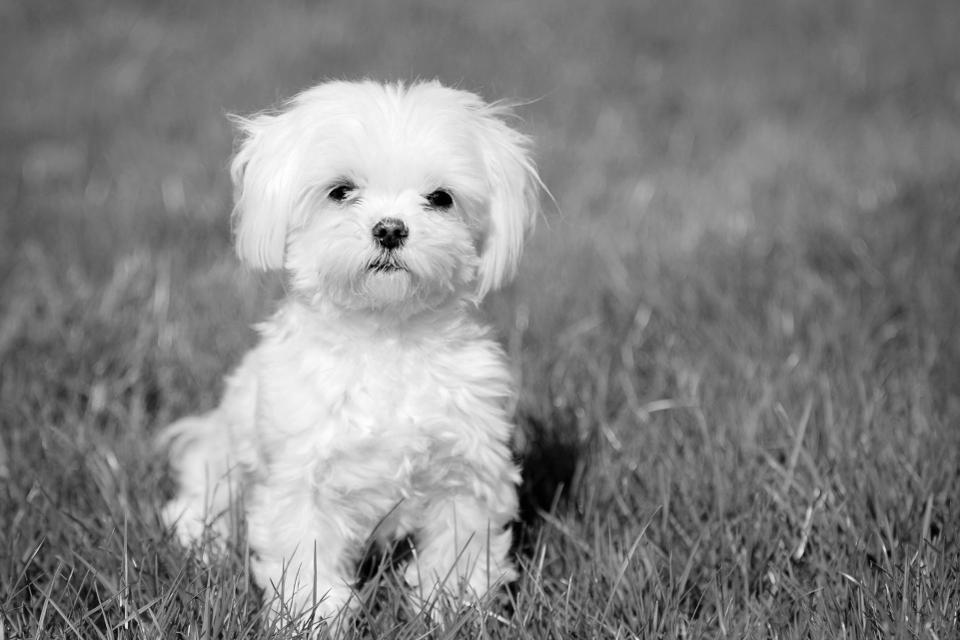

In [ ]:
img = cv2.imread('image.jpg', 0)
cv2_imshow(img)

In [ ]:

h, w = img.shape

img_arr = np.array(img, dtype='int64')

# Initializing the row sum and integral image arrays
s = np.zeros((h, w)) #row sum
ii = np.zeros((h, w)) # integral image
#### YOUR CODE STARTS HERE ####
# Define a function to populate the row sum array s based on img_arr
def populate_row_sum():
  for x in range(h):
    s[x][0] = img_arr[x][0]
    for y in range(1, w):
      s[x][y] = s[x][y-1] + img_arr[x][y]

# Define a function to populate the integral image array ii based on s
def populate_integral_image():
  for y in range(w):
    ii[0][y] = s[0][y]
  for x in range(1, h):
    for y in range(w):
      ii[x][y] = ii[x-1][y] + s[x][y]

# Define a function to find the region sum in the image given upper left pixel co-ordinate (x1,y1) 
# and bottom right pixel co-ordinate (x2,y2) using the computed arrays s and ii with appropiate boundary conditions
def region_sum(x1, y1, x2, y2):
  if x2 < 0 or y2 < 0:
    return 0
  d = ii[x2][y2]
  a = 0
  if x1 > 0 and y1 > 0:
    a = ii[x1-1][y1-1]
  b = 0
  if x1 > 0:
    b = ii[x1-1][y2]
  c = 0
  if y1 > 0:
    c = ii[x2][y1-1]
  return d + a - (b + c)   
#### YOUR CODE ENDS HERE ####



In [ ]:
populate_row_sum()

populate_integral_image()

print(s[90][46], ii[350][720], region_sum(100, 120, 380, 665))

4880.0 36188949.0 25444096.0


## Question 2:

What are the respective values for the quantities s[90][46], ii[350][720], region_sum(100, 120, 380, 665) ?

1.   2880, 12688949, 13923164
2.   4880, 36188949, 25444096
3.   5880, 46188949, 16323164
4.   7880, 56188949, 46323164

Ans-(2)



We will implement Multi-Task Loss for Fast R-CNN by extending the nn class of pythorch. Given the predicted logits, one-hot encoding of actual class labels, ground truth bounding box regression targets and predicted bounding box regression offsets it should return the loss value




In [ ]:
class MultiTaskLoss(nn.Module):
    
    def __init__(self, alpha = 0.1):
        super().__init__()
        self.alpha = alpha
        #### YOUR CODE STARTS HERE ####
        # Initialize a SmoothL1Loss function from the nn class of pytorch with the appropiate reduction param for Fast R-CNN
        self.smooth_l1_loss = nn.SmoothL1Loss(reduction = 'sum')
        #### YOUR CODE ENDS HERE ####

    def forward(self, pred_logits, true_class, bounding_box_offsets, bounding_box_target): # refer the later code for interpretatio of the params
        #### YOUR CODE STARTS HERE ####
        # Calculate predicted class probabilities by taking softmax of predicted logits
        pred = torch.softmax(pred_logits, dim=-1)

        # Calculate the classification loss
        true_class_index = torch.argmax(true_class) #index of the true class
        L_cls = -torch.log(pred[true_class_index])
        # Get the bounding box regression offsets for true class
        t_u = bounding_box_offsets[true_class_index]
        L_loc = 0
        # Calculate localization loss only for non background class
        if true_class_index > 0: # give appropiate condition
          # Calculate the localization loss(smooth L1 loss) between the true bounding box regression targets 
          # and the bounding box offsets computed above while applying the smooth_l1_loss function initialised above
          L_loc = self.smooth_l1_loss(bounding_box_target, t_u)
        
        # Calculate the Multi Task loss from the two losses while using alpha as the scaling factor for the localization loss
        Loss = L_cls + self.alpha * L_loc
        #### YOUR CODE ENDS HERE ####
        return Loss

In [ ]:
# create an object of MultiTaskLoss
mt_loss=MultiTaskLoss(alpha = 0.01)

In [ ]:
# Assume predicted are the predicted logits
predicted_logits=torch.tensor([1.4315, 2.9862, 0.4019, 1.5501])
#One hot encoding of the true class
true_class=torch.tensor([0., 1., 0., 0.])
# Class wise predicted bounding box offsets
bounding_box_offsets = torch.tensor([[25., 51., 82., 120.],[63., 42., 103., 75.],[158., 26., 94., 56.],[15., 86., 44., 80.]])
# Bounding box regression target
bounding_box_target = torch.tensor([58., 35., 108., 81.])

In [ ]:
#### YOUR CODE STARTS HERE ####
#Calculate multi task loss based on the above values
#Use the MultiTaskLossMultiTaskLoss object created above
#Print the value
print(mt_loss(predicted_logits,true_class, bounding_box_offsets, bounding_box_target))
#### YOUR CODE ENDS HERE ####

tensor(0.6317)


## Question 3:

What is the value of the multi-task loss obtained above ?

1.   0.6317
2.   0.7329
3.   1.0435
4.   0.8226

Ans-(1)